<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/Sector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-05-30 14:35:37


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [3]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

from google.colab import data_table

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [4]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-366)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

In [5]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [6]:
sectors = df_nse_sectors['Sector'].unique()
#print(sectors)
#sectors = ['BANKS', 'IT']
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
sector_df_full = df_sectors

In [7]:
def stock_prec_dev(stock_symbol):
    #print(stock_symbol)
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    #stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df['Max']  = round(stock_df['Close'].dropna().max(), 2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)

    #stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Min']  = round(stock_df['Close'].dropna().min(), 2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [8]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,Max,200_SMA,Dev%_200,Sector,Min,RSI_14,ATH%
6,2952.20,3802.31,3291.0,-10.29,MEDIA,1417.53,56.0,28.80
3,13225.75,16437.29,13548.0,-2.38,IT,11636.83,49.0,24.28
14,4175.40,4947.39,4358.0,-4.19,FOOTWEAR,3589.40,66.0,18.49
12,4420.35,5100.03,4575.0,-3.38,JEWELLERY,3751.46,41.0,15.38
10,40291.00,44858.64,40046.0,0.61,CEMENT,14617.05,50.0,11.34
9,21763.60,23420.15,19217.0,13.25,CHEMICAL,15833.32,46.0,7.61
2,9984.95,10620.93,9866.0,1.21,FINANCE,8713.73,52.0,6.37
4,13011.95,13504.04,11247.0,15.69,FMCG,7987.18,54.0,3.78
7,6533.05,6692.35,5318.0,22.85,METAL,4315.46,65.0,2.44
8,26782.35,27331.45,24142.0,10.94,INFRA,19272.41,56.0,2.05


<Axes: xlabel='Date'>

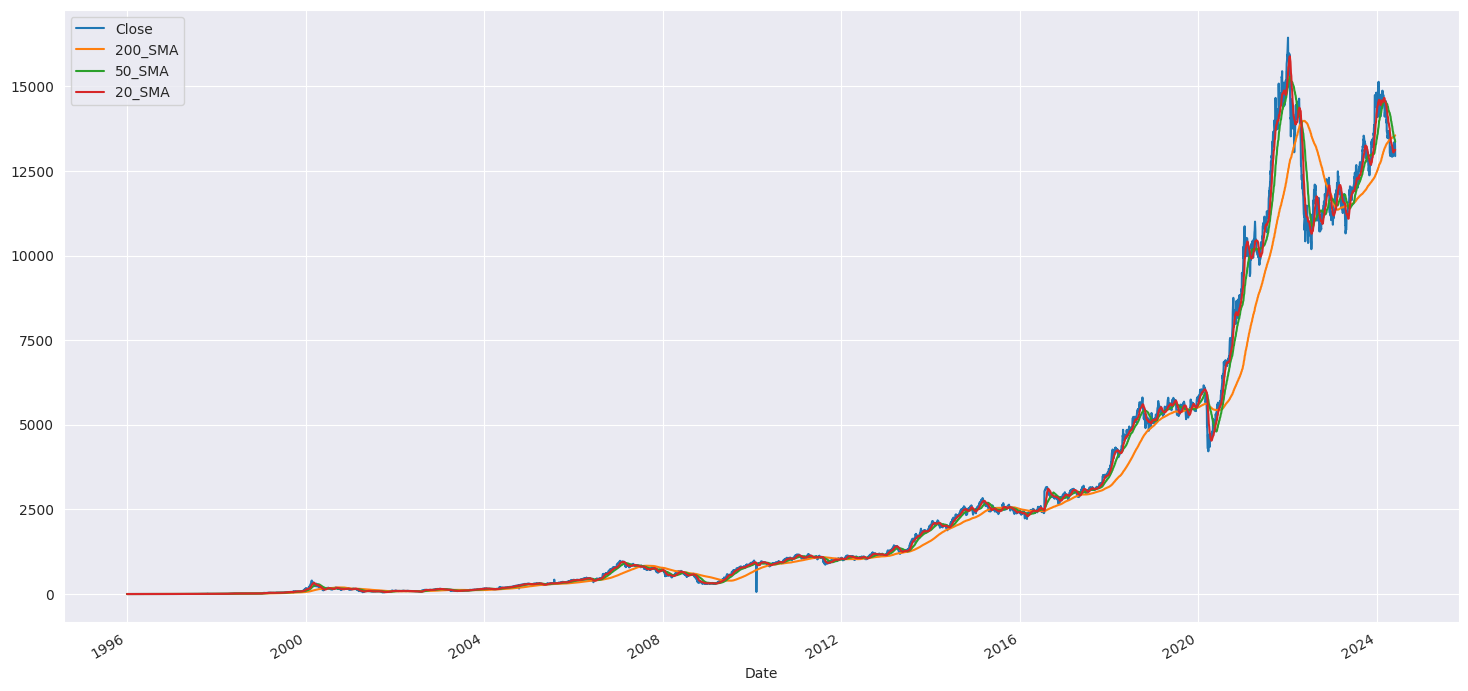

In [9]:
col = ['IT']
sector_df = sector_df_full[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [10]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR
Date,,,,,,,,,,,,,,,
2023-05-30 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-05-31 00:00:00+05:30,99.794291,99.819041,99.675128,100.018162,101.290358,100.820342,100.386354,99.286772,99.817578,100.227329,98.730936,102.034393,100.527648,99.401920,99.414247
2023-06-01 00:00:00+05:30,100.065677,98.225326,100.237924,100.114329,101.255237,101.615832,100.460669,99.050936,100.506439,100.160122,98.898109,102.847197,100.627209,99.982585,99.502253
2023-06-02 00:00:00+05:30,101.736283,98.622161,100.230548,100.106019,101.765244,102.143103,100.085883,99.033938,101.515080,100.096312,98.653729,103.223364,102.374845,100.505668,99.509420
2023-06-05 00:00:00+05:30,102.587771,98.909397,100.505550,99.489740,101.812251,101.832626,101.620410,98.893004,101.888544,99.769381,98.148179,103.215826,102.852553,101.018804,99.636702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23 00:00:00+05:30,167.344425,104.887507,114.319401,111.175994,139.535150,143.166872,104.922923,148.740617,140.401762,137.217727,108.580811,196.773561,121.218067,118.072499,97.277475
2024-05-24 00:00:00+05:30,167.627666,105.246873,114.774096,110.601133,138.673619,142.185945,104.614176,148.281658,140.511564,137.135524,108.055185,196.386376,119.649341,117.782521,96.953712
2024-05-27 00:00:00+05:30,167.117827,105.809941,115.853927,111.108560,138.275373,143.089695,105.518749,145.873532,140.594692,135.045126,107.899703,196.764601,119.236169,116.013105,97.109684


In [11]:
cols = df_sectors.columns
for col in cols:
  median = df_sectors.loc[df_sectors[col]< 90, col].median()
  df_sectors.loc[df_sectors[col] < 90, col] = np.nan
  df_sectors[col] = np.where(df_sectors[col] < 90, median,df_sectors[col])

<Axes: xlabel='Date'>

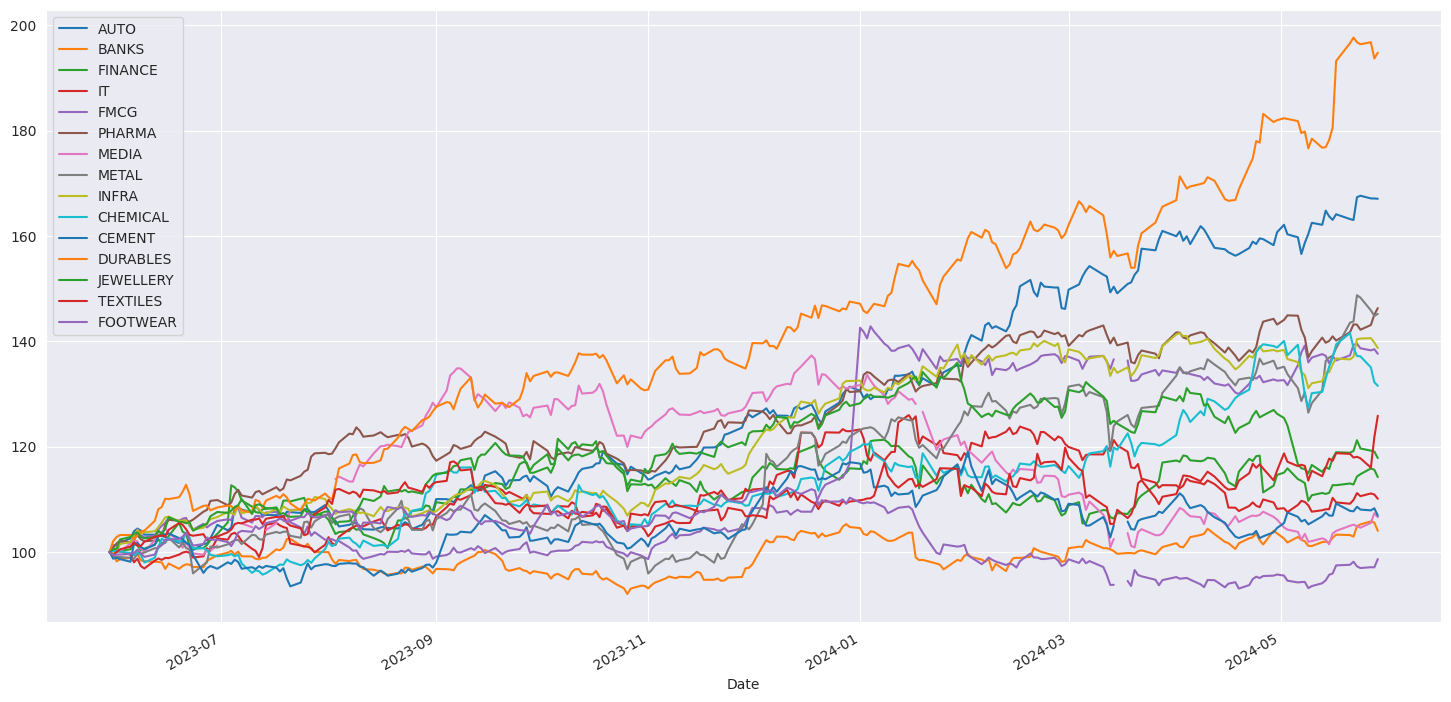

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=sectors, figsize=(18,9))

In [13]:
tmp_df

,Date,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR
0,2023-05-30 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2023-05-31 00:00:00+05:30,99.794291,99.819041,99.675128,100.018162,101.290358,100.820342,100.386354,99.286772,99.817578,100.227329,98.730936,102.034393,100.527648,99.401920,99.414247
2,2023-06-01 00:00:00+05:30,100.065677,98.225326,100.237924,100.114329,101.255237,101.615832,100.460669,99.050936,100.506439,100.160122,98.898109,102.847197,100.627209,99.982585,99.502253
3,2023-06-02 00:00:00+05:30,101.736283,98.622161,100.230548,100.106019,101.765244,102.143103,100.085883,99.033938,101.515080,100.096312,98.653729,103.223364,102.374845,100.505668,99.509420
4,2023-06-05 00:00:00+05:30,102.587771,98.909397,100.505550,99.489740,101.812251,101.832626,101.620410,98.893004,101.888544,99.769381,98.148179,103.215826,102.852553,101.018804,99.636702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2024-05-23 00:00:00+05:30,167.344425,104.887507,114.319401,111.175994,139.535150,143.166872,104.922923,148.740617,140.401762,137.217727,108.580811,196.773561,121.218067,118.072499,97.277475
241,2024-05-24 00:00:00+05:30,167.627666,105.246873,114.774096,110.601133,138.673619,142.185945,104.614176,148.281658,140.511564,137.135524,108.055185,196.386376,119.649341,117.782521,96.953712
242,2024-05-27 00:00:00+05:30,167.117827,105.809941,115.853927,111.108560,138.275373,143.089695,105.518749,145.873532,140.594692,135.045126,107.899703,196.764601,119.236169,116.013105,97.109684
243,2024-05-28 00:00:00+05:30,167.109916,105.585543,115.614281,110.913334,138.489037,145.038808,107.354968,144.802262,139.747879,132.220961,108.295980,193.679468,119.060237,121.783693,97.087235
